In [1]:
%env CUDA_VISIBLE_DEVICES=3
import sys
sys.path.append('/home/a_razumov/projects/k-space-mri')
import numpy as np
import pylab as plt
import pickle
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F

from k_space_reconstruction.utils.metrics import pt_msssim, pt_ssim
from k_space_reconstruction.datasets.acdc import ACDCSet, ACDCTransform, RandomMaskFunc
from k_space_reconstruction.datasets.fastmri import FastMRIh5Dataset, FastMRITransform, LegacyFastMRIh5Dataset
from k_space_reconstruction.utils.kspace import EquispacedMaskFunc, RandomMaskFunc
from k_space_reconstruction.utils.kspace import pt_spatial2kspace as Ft
from k_space_reconstruction.utils.kspace import pt_kspace2spatial as IFt

import os
import sys
from k_space_reconstruction.nets.unet import Unet
from k_space_reconstruction.nets.enet import ENet
from k_space_reconstruction.nets.mwcnn import MWCNN
import datetime
import torch
import torchvision
import numpy as np
import pylab as plt
plt.style.use('dark_background')
import albumentations
import numpy as np
import h5py
import pylab as plt
import torch
import torch.nn.functional as F

import os
import re
import numpy as np
import pandas as pd
import nibabel

import torch
import torch.utils.data
import torchvision.transforms as transforms
import torchio

from os.path import isdir, join
from typing import Callable, Dict, List, Any

env: CUDA_VISIBLE_DEVICES=3


In [2]:
fig_bezzeless = lambda nc, nr : plt.subplots(ncols=nc, nrows=nr, figsize=(2 * nc, 4), dpi=100, 
                                             subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                                             gridspec_kw=dict(wspace=0.0, hspace=0.0))

def dice_loss(true, logits, eps=1e-11):
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = torch.nn.functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

def dice_coeff_3d_classes(true, logits, eps=1e-11):
    num_classes = logits.shape[0]
    probas = torch.nn.functional.softmax(logits, dim=0)
    probas[probas > 0.5] = 1
    probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(true).float()
    for i in range(1, num_classes): pmask[0] += probas[i] * i
    dice_ls = []
    # WT
    true_1_hot = ((true==1) | (true==2) | (true==3)).float().flatten()
    pred_1_hot = ((pmask==1) | (pmask==2) | (pmask==3)).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)).item())
    # ET
    true_1_hot = ((true==1) | (true==3)).float().flatten()
    pred_1_hot = ((pmask==1) | (pmask==3)).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)).item())
    # TC
    true_1_hot = ((true==1)).float().flatten()
    pred_1_hot = ((pmask==1)).float().flatten()
    intersection = torch.sum(pred_1_hot * true_1_hot)
    cardinality = torch.sum(pred_1_hot + true_1_hot)
    dice_ls.append((2. * intersection / (cardinality + eps)).item())
    return dice_ls

def train_sampling_pattern(train_generator, model, n=16, verbose=True):
    w = torch.zeros(4,240).cuda().float()
    w[:,120] = 1
    w_list = []
    bbatch_size = 110
    for count in range(int(n * 110 / len(train_generator) + 1)):
        w = torch.autograd.Variable(w, requires_grad=True)
        pbar = tqdm(enumerate(train_generator), total=len(train_generator), leave=False, disable=not verbose)
        for I, (mask, img, mean, std) in pbar:
            mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
            ks = Ft(img * std + mean)
            img = (IFt(ks * w.unsqueeze(0).unsqueeze(3)).abs() - mean) / (std + 1e-11)
            pred = model(img)
            loss = dice_loss(mask, pred)
            if torch.isnan(loss):
                print('warn')
                continue
            loss.backward()
            if (I != 0) and (I % 110 == 0):
                w_grad = w.grad.cpu().detach()
                w = w.detach()
                for j in range(4):
                    for i in torch.topk(w_grad[j,:], 240, largest=False).indices:
                        if w[j,i] == 0: 
                            w[j,i] = 1.
                            pbar.set_description('select: %d, loss: %.6f' % (i.item(), loss.item()))
                            break
                w_list.append(w.clone())
                w = torch.autograd.Variable(w, requires_grad=True)
                if len(w_list) > n: break
    return w_list

def test_sampling_pattern(sampling, model, val_generator):
    dice_scores = []
    with torch.no_grad():
        for mask, img, mean, std in tqdm(val_generator):
            mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
            ks = Ft(img * std + mean)
            img = (IFt(ks * sampling).abs() - mean) / (std + 1e-11)
            pred = model(img)
            dice_scores.append(1 - dice_loss(mask, pred).item())
    return dice_scores

def test_3d_sampling_pattern(sampling, model, val_3d_dataset):
    dice_scores = []
    with torch.no_grad():
        for i in tqdm(range(len(val_3d_dataset))):
            mask, img, mean, std = val_3d_dataset[i]
            mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
            ks = Ft(img * std + mean)
            img = (IFt(ks * sampling).abs() - mean) / (std + 1e-11)
            if i==0: plt.imshow(img[0,90].cpu().detach()); plt.show()
            pred = model(img.movedim(1,0))
            dice_scores.append(np.mean(dice_coeff_3d_classes(mask, pred.movedim(1,0))))
    return dice_scores

def test_3d_on_classes_sampling_pattern(sampling, model, val_3d_dataset):
    dice_scores = []
    with torch.no_grad():
        for i in tqdm(range(len(val_3d_dataset))):
            mask, img, mean, std = val_3d_dataset[i]
            mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
            ks = Ft(img * std + mean)
            img = (IFt(ks * sampling).abs() - mean) / (std + 1e-11)
            if i==0: plt.imshow(img[0,90].cpu().detach()); plt.show()
            pred = model(img.movedim(1,0))
            dice_scores.append(dice_coeff_3d_classes(mask, pred.movedim(1,0)))
    return dice_scores


class BraTS3dDataset(torch.utils.data.Dataset):

    def __init__(self, hf_path: str, aug=None, indexes=None):
        super().__init__()
        self.hf = h5py.File(hf_path)
        self.aug = aug
        if indexes is not None:
            self.indexes = [str(i) for i in indexes]
        else:
            self.indexes = [k for k in self.hf.keys()]

    def __len__(self) -> int:
        return len(self.indexes)
    
    def __getitem__(self, item: int):
        key = self.indexes[item]
        img = self.hf[key][:-1,:,:,:]
        mask = self.hf[key][-1:,:,:,:]
        mask[mask==4] = 3
        if self.aug:
            aug = self.aug(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']
        img = torch.tensor(img).float()
        mask = torch.tensor(mask).long()
        img = img.movedim(3,1)
        mask = mask.movedim(3,1)
        mean = img.mean(dim=(2,3)).unsqueeze(2).unsqueeze(2)
        std = img.std(dim=(2,3)).unsqueeze(2).unsqueeze(2)
        img = (img - mean) / (std + 1e-11)
        return mask, img, mean, std


class BraTS2dDataset(torch.utils.data.Dataset):

    def __init__(self, hf_path: str, aug1=None, aug2=None, slices=None, indexes=None):
        super().__init__()
        self.hf = h5py.File(hf_path)
        self.aug1 = aug1
        self.aug2 = aug2
        if slices:
            self.slices = slices
        else:
            self.slices = []
            for k in tqdm(self.hf.keys()):
                for j in range(self.hf[k].shape[-1]):
                    if self.hf[k][:,:,:,j].max() != 0.:
                        self.slices.append((k, j))
        if indexes is not None:
            self.slices = [s for s in self.slices if int(s[0]) in indexes]

    def __len__(self) -> int:
        return len(self.slices)
    
    def __getitem__(self, item: int):
        key, idx = self.slices[item]
        img = self.hf[key][:-1,:,:,idx]
        mask = self.hf[key][-1:,:,:,idx]
        mask[mask==4] = 3
        if self.aug1:
            aug = self.aug1(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']
        img = torch.tensor(img).float()
        if self.aug2:
            img = self.aug2(img.unsqueeze(0))[0]
        mask = torch.tensor(mask).long()
        mean = img.mean().unsqueeze(0).unsqueeze(0).unsqueeze(0)
        std = img.std().unsqueeze(0).unsqueeze(0).unsqueeze(0)
        img = (img - mean) / (std + 1e-11) + 1e-11
        return mask, img, mean, std

In [3]:
def pt_psnr(img1, img2, maxval):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(maxval / torch.sqrt(mse))

In [4]:
np.random.seed(42)
torch.manual_seed(42)

with open('brats_train.cache', 'rb') as f:
    train_slices_cache = pickle.load(f)
with open('brats_val.cache', 'rb') as f:
    val_slices_cache = pickle.load(f)

train_dataset = BraTS2dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5', slices=train_slices_cache)
val_dataset = BraTS2dDataset('/home/a_razumov/small_datasets/brats_h5/val.h5', slices=val_slices_cache)
train_3d_dataset = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5')
val_3d_dataset = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/val.h5')
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=32)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=32)

In [5]:
len(train_dataset), len(val_dataset), len(train_3d_dataset), len(val_3d_dataset)

(35508, 15391, 258, 111)

In [6]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = Unet(4, 4).to(device).train(False).eval()
for p in model.parameters():
    p.requires_grad = False
model.load_state_dict(torch.load('unet-brats-norot-3.pt'))

<All keys matched successfully>

# 5-fold validation x16 3D dice

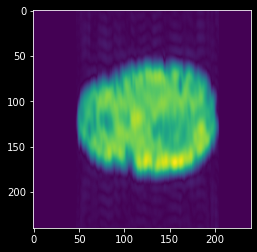

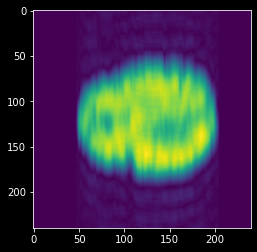

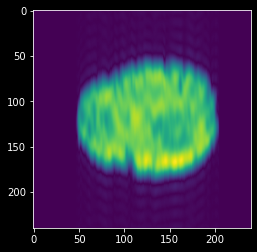

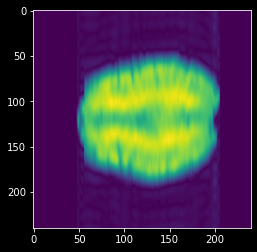

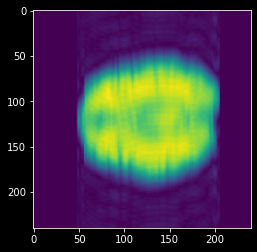

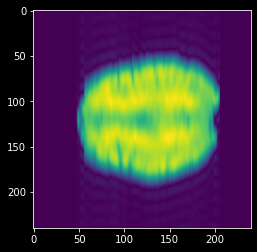

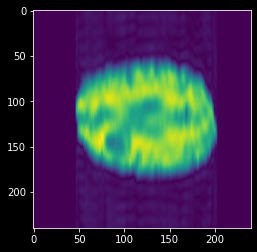

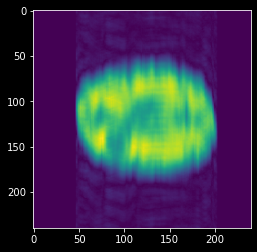

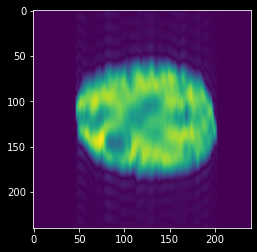

--- Logging error ---
Traceback (most recent call last):
  File "/home/a_razumov/miniconda3/envs/k-space-mri-p38/lib/python3.8/logging/__init__.py", line 1085, in emit
    self.flush()
  File "/home/a_razumov/miniconda3/envs/k-space-mri-p38/lib/python3.8/logging/__init__.py", line 1065, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/home/a_razumov/miniconda3/envs/k-space-mri-p38/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/a_razumov/miniconda3/envs/k-space-mri-p38/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/a_razumov/miniconda3/envs/k-space-mri-p38/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/a_razumov/miniconda3/envs/k-space-mri-p38/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/home/a

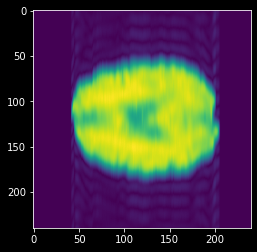

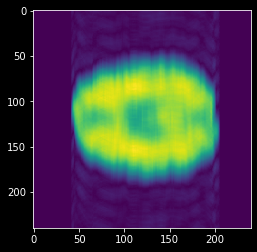

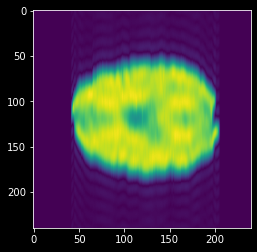

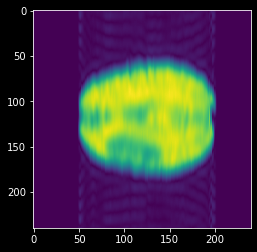

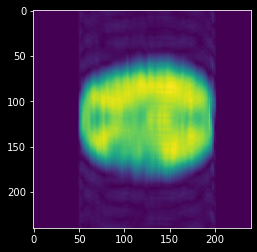

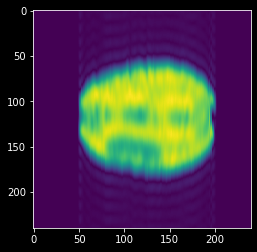

In [7]:
import contextlib
from collections import defaultdict
from sklearn.model_selection import KFold

fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [15])((240, 240))[0]).cuda().float().unsqueeze(1).unsqueeze(0).unsqueeze(0)
zm = torch.zeros(240).cuda().float()
zm[240//2 - int(16)//2 : 240//2 + int(16)//2] = 1
zm = zm.unsqueeze(1).unsqueeze(0).unsqueeze(0)
fm = torch.ones(240).cuda().float()

dice_fold_scores = defaultdict(dict)

for i, (train_id, val_id) in enumerate(tqdm(KFold(shuffle=False).split(range(len(train_3d_dataset))))):
    td = BraTS2dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5', slices=train_slices_cache, indexes=train_id)
    vd = BraTS3dDataset('/home/a_razumov/small_datasets/brats_h5/train.h5', indexes=val_id)
    tg = torch.utils.data.DataLoader(td, batch_size=32, shuffle=True, num_workers=18)
    with contextlib.redirect_stdout(None):
        w_list = train_sampling_pattern(tg, model, n=15, verbose=False)
    dice_fold_scores[i] = dict(
        ours=test_3d_sampling_pattern(w_list[14].unsqueeze(2).unsqueeze(1), model, vd),
        fastmri=test_3d_sampling_pattern(fastmri_mask_x16, model, vd), 
        center=test_3d_sampling_pattern(zm, model, vd),
    )

In [8]:
fold_scores = [vd for vd in dice_fold_scores.values()]
with open('unet_fold_scores.pkl', mode='wb') as f: pickle.dump(fold_scores, f)

In [9]:
with open('unet_fold_scores.pkl', 'rb') as f: fold_scores = pickle.load(f)

In [10]:
import scipy

df_dice = pd.DataFrame.from_dict({
    'fastmri': [np.mean(v['fastmri']) for v in fold_scores],
    'center': [np.mean(v['center']) for v in fold_scores],
    'ours': [np.mean(v['ours']) for v in fold_scores]
})
print(scipy.stats.ttest_rel(df_dice.center, df_dice.ours))
df_dice.describe()

Ttest_relResult(statistic=-16.289918326776064, pvalue=8.310801229710369e-05)


,fastmri,center,ours
count,5.000000,5.000000,5.000000
mean,0.523101,0.618214,0.653133
std,0.008307,0.006365,0.004814
min,0.513531,0.610757,0.646038
25%,0.515613,0.613582,0.651601
50%,0.525645,0.617376,0.653527
75%,0.527479,0.624074,0.655517
max,0.533236,0.625280,0.658980


# Train of full train

In [ ]:
tg = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=32)
w = train_sampling_pattern(tg, model, n=15)[14]
torch.save(w, 'sampling_igs.pt')

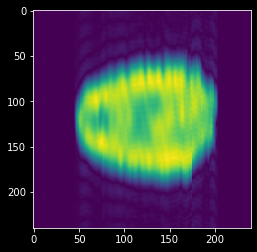

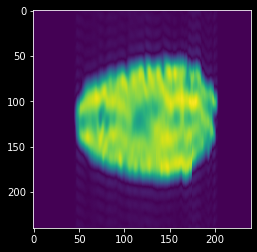

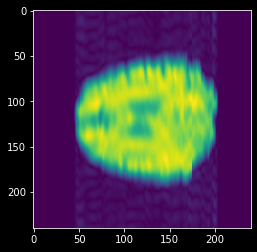

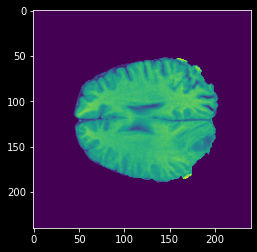

In [7]:
fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [15])((240, 240))[0]).cuda().float().unsqueeze(1).unsqueeze(0).unsqueeze(0)
zm = torch.zeros(240).cuda().float()
zm[240//2 - int(16)//2 : 240//2 + int(16)//2] = 1
zm = zm.unsqueeze(1).unsqueeze(0).unsqueeze(0)
fm = torch.ones(240).cuda().float()
w = torch.load('sampling_igs.pt')

dice_scores = dict(
    fastmri=test_3d_on_classes_sampling_pattern(fastmri_mask_x16, model, val_3d_dataset), 
    center=test_3d_on_classes_sampling_pattern(zm, model, val_3d_dataset),
    ours=test_3d_on_classes_sampling_pattern(w.unsqueeze(2).unsqueeze(1), model, val_3d_dataset),
    full=test_3d_on_classes_sampling_pattern(fm, model, val_3d_dataset)
)

In [8]:
class_map = {0: 'WT', 1: 'ET', 2: 'TC'}
for name in dice_scores.keys():
    arr = np.array(dice_scores[name]).T
    print('##############', name, '##############')
    print(pd.DataFrame.from_dict({class_map[i]:arr[i] for i in range(arr.shape[0])}).describe())

############## fastmri ##############
               WT          ET          TC
count  111.000000  111.000000  111.000000
mean     0.624634    0.450991    0.231165
std      0.176612    0.267298    0.227001
min      0.031378    0.000000    0.000000
25%      0.523688    0.225941    0.019135
50%      0.664542    0.539197    0.165666
75%      0.768445    0.670045    0.431632
max      0.876915    0.850040    0.751791
############## center ##############
               WT          ET          TC
count  111.000000  111.000000  111.000000
mean     0.699862    0.548143    0.315827
std      0.165725    0.281631    0.264750
min      0.016651    0.000000    0.000000
25%      0.617658    0.349714    0.039512
50%      0.747945    0.652433    0.297449
75%      0.817712    0.772635    0.554746
max      0.911240    0.877907    0.864507
############## ours ##############
               WT          ET          TC
count  111.000000  111.000000  111.000000
mean     0.744052    0.563335    0.324507
std     

In [10]:
sum([np.prod(p.size()) for p in model.parameters()])

7757060

In [9]:
mask, img, mean, std = val_3d_dataset[1]
mask = mask.cuda(); img = img.cuda(); mean = mean.cuda(); std = std.cuda()
ks = Ft(img * std + mean)
img = (IFt(ks * fm).abs() - mean) / (std + 1e-11)
pred = model(img.movedim(1,0)).movedim(1,0)
print(dice_coeff_3d_classes(mask, pred))
probas = torch.nn.functional.softmax(pred, dim=0)
probas[probas > 0.5] = 1
probas[probas <= 0.5] = 0
pmask = torch.zeros_like(mask).float()
for i in range(1, 4): pmask[0] += probas[i] * i

[0.9576348662376404, 0.502840518951416, 0.46984678506851196]


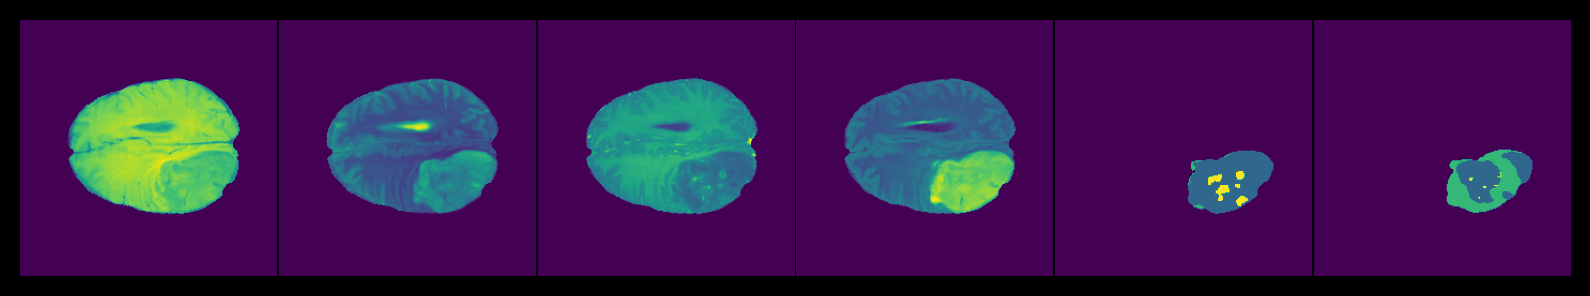

In [10]:
z = 100
fig, ax = plt.subplots(figsize=(10,10), ncols=6, dpi=200,
                       subplot_kw=dict(frameon=False, xticks=[], yticks=[]),
                       gridspec_kw=dict(wspace=0.01, hspace=0.0))
ax[0].imshow(img[0,z].cpu())
ax[1].imshow(img[1,z].cpu())
ax[2].imshow(img[2,z].cpu())
ax[3].imshow(img[3,z].cpu())
ax[4].imshow(mask[0,z].cpu())
ax[5].imshow(pmask[0,z].cpu())
plt.show()